Assignment 6: Convolutional Networks
====================================


Microsoft Forms Document: https://forms.office.com/r/89d0K2m5yr


Before we start, we should assure that we have activated CUDA -- otherwise training might take very long.
In Google Colaboratory:

1. Check the options Runtime -> Change Runtime Type on top of the page.
2. In the popup window, select hardware accelerator GPU.

Afterward, the following command should run successfully:

In [34]:
import torch
if torch.cuda.is_available():
  print("Successfully enabled CUDA processing")
else:
  print("CUDA processing not available. Things will be slow :-(")

Successfully enabled CUDA processing


Task 1: Dataset Loading
-----------------------

Here, we use the MNIST dataset of handwritten digits for categorical classification.

Write a function that returns the training and the test set of MNIST, using the given transform.

In [35]:
import torch
import torchvision

def datasets(transform):
  trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
  testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

  return trainset, testset

Test 1: Data Types
------------------

Create the dataset with `transform=None`. Check that all inputs are of type `PIL.Image.Image`, and all targets are integral.

In [36]:
import PIL
trainset, testset = datasets(None)

for x,t in trainset:
  # check datatype of input x
  assert isinstance(x,PIL.Image.Image)
  assert x.size == (28,28) ### 对于 PIL.Image.Image 要用 .size 确定他的大小
  # check datatype of target t
  assert isinstance(t,int) and 0 <= t <= 9

print("Single Img Size is (28,28)")
print("Target is int and 0 <= t <= 9")
print("Successful!")

Single Img Size is (28,28)
Target is int and 0 <= t <= 9
Successful!


Task 2: Data Loaders
--------------------

Create the dataset with `transform=torchvision.transforms.ToTensor()`. Create two data loaders, one for the training set and one for the test set. The training batch size should be $B=64$, for the test set, you can choose any batch size of your choice.


In [37]:
transform = torchvision.transforms.ToTensor() #transforms 单词别写错了

trainset, testset = datasets(transform)

B = 64
trainloader = torch.utils.data.DataLoader(dataset=trainset, shuffle=True, batch_size=B)
testloader = torch.utils.data.DataLoader(dataset=testset, shuffle=False, batch_size=B*2)

Test 2: Batches
---------------

Check that all batches generated by the training set data loader have the batch size of $B$ -- except for the last batch. Check that all inputs and targets are of type `torch.Tensor`. Check that all input values are in range $[0,1]$. Check that all target values are in range $[0,9]$.

In [38]:
for i,(x,t) in enumerate(trainloader):
  # check datatype, size and content of x

  if (i != len(trainloader)-1): ### 如果不是最后一个
    assert x.shape[0] == B and t.shape[0] == B

  assert isinstance(x,torch.Tensor) ### type(x) == torch.Tensor
  assert (x>=0).all() and torch.all(x<=1) ### 两种all的写法都可以，就是不能单独写 all()
  
  # check datatype, size and content of t
  assert type(t) == torch.Tensor
  assert torch.all(t >= 0) and torch.all(t <= 9)

Task 3: Fully-Connected Network
-------------------------------

Implement a function that returns a three-layer fully-connected network in pytorch.
Use $\tanh$ as activation function between the two fully-connected layers, and provide the possibility to change the number of inputs $D$, the number of hidden neurons $K$ and the number of outputs $O$.
Use the following layers:

1. A `torch.nn.Flatten` layer to turn the $28\times28$ pixel image (2D) into a $28*28$ pixel vector (1D)
2. A fully-connected layer with D input neurons and K outputs.
3. A $\tanh$ activation function.
4. A fully-connected layer with K input neurons and K outputs.
5. A $\tanh$ activation function.
6. A fully-connected layer with K input neurons and O outputs.

In [39]:
def fully_connected(D, K, O):
  return torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(D,K),
    torch.nn.Tanh(),
    torch.nn.Linear(K,K),
    torch.nn.Tanh(),
    torch.nn.Linear(K,O)
  )

Task 4: Convolutions Output (theoretical question)
--------------------------------------------------

Consider the network as defined in Task 5.
Assume that the input is a $28\times28$ grayscale image.
How many hidden neurons do we need in the final fully-connected layer for a given number $Q_2$ of output channels of the second convolution?

\begin{aligned}
& \text{Given input size $28\times28$} \\
& \downarrow \\
& Q_1 \times 28 \times 28 \text{~ By Op.1. 2D convolutional layer with Q1 channels, kernel size 5 × 5, stride 1 and padding 2 } \\
& \downarrow \\
& Q_1 \times 14 \times 14 \text{~ By Op.2. 2Dmaximumpoolinglayerwithkernelsize2×2and stride 2} \\
& \downarrow \\
& Q_2 \times 14 \times 14 \text{~ By Op.3. tanh and Op.4. 2D convolutional layer with Q2 channels, kernel size
5 × 5, stride 1 and padding 2} \\
& \downarrow \\
& Q_2 \times 7 \times 7 \text{~ By Op.5. 2Dmaximumpoolinglayerwithkernelsize2×2and
stride 2 and Op.6. tanh} \\
& \downarrow \\
& Q_2 \cdot 7 \cdot 7 \rightarrow \text{the size of the flattened vector}
\end{aligned}



size after first convolution:\
Conv2 = $28\times28\times Q_1$

\
size after first MaxPool2D:\
MP2 = $(\frac{28}{kernel size}+2-strides)\times(\frac{28}{kernel size}+2-strides)\times Q_1$
\
MP2= $(\frac{28}{2}+2-2)\times(\frac{28}{2}+2-2)\times Q_1$
\
MP2 = $14\times14\times Q_1$

\
size after second convolution:\
Conv2 = $14\times14\times Q_2$

\
size after second MaxPool2D:\
MP2 = $(\frac{14}{kernel size}+2-strides)\times(\frac{14}{kernel size}+2-strides)\times Q_2$
\
MP2= $(\frac{14}{2}+2-2)\times(\frac{14}{2}+2-2)\times Q_2$
\
MP2 = $7\times7\times Q_2$


\
size after flatten:\
flatten1 = 7 * 7 * $Q_2$ = 49 * $Q_2$

\
Overall:
$(\frac{28}{2^2})\times(\frac{28}{2^2})\times Q_2$
<font color="#dd0000"> answer: $7*7*Q_2$ </font>

Task 5: Convolutional Network
-----------------------------

Implement a function that generates a convolutional network wit the following layers:

1. 2D convolutional layer with $Q_1$ channels, kernel size $5\times5$, stride 1 and padding 2.
2. 2D maximum pooling with pooling size $2\times2$ and stride 2
3. $\tanh$ activation
4. 2D convolutional layer with $Q_2$ channels, kernel size $5\times5$, stride 1 and padding 2.
5. 2D maximum pooling with pooling size $2\times2$ and stride 2
6. $\tanh$ activation
7. A flattening layer to turn the 3D image into 1D vector
8. A fully-connected layer with the appropriate number of inputs and $O$ outputs.

In [40]:
from torch.nn.modules import pooling
def convolutional(Q1, Q2, O):
  return torch.nn.Sequential(
    #https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
    torch.nn.Conv2d(in_channels=1, out_channels=Q1, kernel_size=(5,5), stride=1, padding=2),
    #https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html#torch.nn.MaxPool2d
    torch.nn.MaxPool2d(kernel_size=(2,2),stride=2),
    torch.nn.Tanh(),
    torch.nn.Conv2d(in_channels=Q1, out_channels=Q2,kernel_size=(5,5), stride=1, padding=2),
    torch.nn.MaxPool2d(kernel_size=(2,2),stride=2),
    torch.nn.Tanh(),
    torch.nn.Flatten(),
    torch.nn.Linear(in_features=7*7*Q2, out_features=O)
  )

Task 6: Training and Validation Loop
------------------------------------

Implement a function that takes the network, the number of epochs and the learning rate.
Select the correct loss function for categorical classification, and SGD optimizer.
Iterate the following steps for the given number of epochs:

1. Train the network with all batches of the training data
2. Compute the test set loss and test set accuracy
3. Store both in a vector

What do we need to take care of?

Finally, return the lists of validation losses and accuracies.

In [41]:
def train(network, epochs=100, eta=0.01):
  # select loss function and optimizer
  loss = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(
      params=network.parameters(),
      lr = eta,
      momentum = 0.9
      )

  # instantiate the correct device
  device = torch.device("cuda")
  network = network.to(device)

  # collect loss values and accuracies over the training epochs
  val_loss, val_acc = [], []

  for epoch in range(epochs):
    print("epoch:",epoch)
    # train network on training data
    for x,t in trainloader:
      x = x.to(device)
      t = t.to(device)
      optimizer.zero_grad()
      z = network(x)
      J = loss(z,t)
      J.backward()
      optimizer.step()

    # test network on test data
    with torch.no_grad():
      total_loss = 0
      total_correct = 0
      for x,t in testloader:
        x = x.to(device)
        t = t.to(device)
        z = network(x)
        J = loss(z,t) ### 注意！！！ CrossEntropyLoss计算的是样本均值loss
        total_loss += J.item()*len(t) ### 最后一个batch的数量不一样，所以按照每个batch的数据量把 平均 loss 相乘
        total_correct += (z.argmax(dim=1) == t).sum().item() ### dim/axis都一样 item() 只对标量有用 eg. tensor([1]) -> 1
      
      print("epoch_loss:",total_loss / len(testset))
      print("epoch_acc:",total_correct / len(testset))
      val_loss.append(total_loss / len(testset)) ### 这里不能直接除以 len(testloader)batch的数量1000/64 或者 len(testset) 全test样本总数10000
      val_acc.append(total_correct / len(testset))

  # return loss and accuracy values
  return val_loss, val_acc

Task 7: Fully-Connected Training
--------------------------------

Create a fully-connected network with $K=10$ hidden and $O=10$ output neurons.
Train the network for 10 epochs with $\eta=0.01$ and store the obtained test losses and accuracies.
Brave people can also train for 100 epochs (takes up to 30 minutes).

In [42]:
fc = fully_connected(D=28*28,K=10,O=10)
fc_loss, fc_acc = train(fc)

epoch: 0
epoch_loss: 0.36459394283294677
epoch_acc: 0.8943
epoch: 1
epoch_loss: 0.2981039562702179
epoch_acc: 0.9116
epoch: 2
epoch_loss: 0.2737415664434433
epoch_acc: 0.9163
epoch: 3
epoch_loss: 0.27047414560317995
epoch_acc: 0.9179
epoch: 4
epoch_loss: 0.2588599971294403
epoch_acc: 0.9208
epoch: 5
epoch_loss: 0.2528420949101448
epoch_acc: 0.9232
epoch: 6
epoch_loss: 0.25673067774772645
epoch_acc: 0.923
epoch: 7
epoch_loss: 0.24450307664871215
epoch_acc: 0.927
epoch: 8
epoch_loss: 0.24495358089208602
epoch_acc: 0.9259
epoch: 9
epoch_loss: 0.24042293531894685
epoch_acc: 0.929
epoch: 10
epoch_loss: 0.24581825811862945
epoch_acc: 0.9278
epoch: 11
epoch_loss: 0.2405710914373398
epoch_acc: 0.9287
epoch: 12
epoch_loss: 0.24156265969276428
epoch_acc: 0.9276
epoch: 13
epoch_loss: 0.246578948032856
epoch_acc: 0.9263
epoch: 14
epoch_loss: 0.22931599606275557
epoch_acc: 0.9347
epoch: 15
epoch_loss: 0.22927305133342743
epoch_acc: 0.9318
epoch: 16
epoch_loss: 0.22875031366348267
epoch_acc: 0.9322


Task 8: Convolutional Training
------------------------------

Create a convolutional network with $Q_1=32$ and $Q_2=64$ convolutional channels and $O=10$ output neurons.
Train the network for 10 epochs with $\eta=0.01$ and store the obtained test losses and accuracies.
Brave people can also train for 100 epochs (takes up to 30 minutes).

In [43]:
cv = convolutional(Q1=32,Q2=64,O=10)
cv_loss, cv_acc = train(cv)

epoch: 0
epoch_loss: 0.06548385546654463
epoch_acc: 0.9804
epoch: 1
epoch_loss: 0.04341879126392305
epoch_acc: 0.986
epoch: 2
epoch_loss: 0.03830149580454454
epoch_acc: 0.9874
epoch: 3
epoch_loss: 0.03292471926836297
epoch_acc: 0.9895
epoch: 4
epoch_loss: 0.02946316513437778
epoch_acc: 0.9897
epoch: 5
epoch_loss: 0.033214529661228884
epoch_acc: 0.9894
epoch: 6
epoch_loss: 0.02971442074859515
epoch_acc: 0.9898
epoch: 7
epoch_loss: 0.02777267246330157
epoch_acc: 0.9904
epoch: 8
epoch_loss: 0.029753938910807482
epoch_acc: 0.9904
epoch: 9
epoch_loss: 0.027285701985936613
epoch_acc: 0.9901
epoch: 10
epoch_loss: 0.02945213108297903
epoch_acc: 0.9899
epoch: 11
epoch_loss: 0.026895919096050783
epoch_acc: 0.9905
epoch: 12
epoch_loss: 0.026168941649934278
epoch_acc: 0.9905
epoch: 13
epoch_loss: 0.027595847953367048
epoch_acc: 0.9901
epoch: 14
epoch_loss: 0.02708830438188743
epoch_acc: 0.9905
epoch: 15
epoch_loss: 0.027038620322267524
epoch_acc: 0.9901
epoch: 16
epoch_loss: 0.026218437658378387
e

Task 9: Plotting
----------------

Plot the two lists of loss values in one plot. Plot the two lists of accuracy values into another.

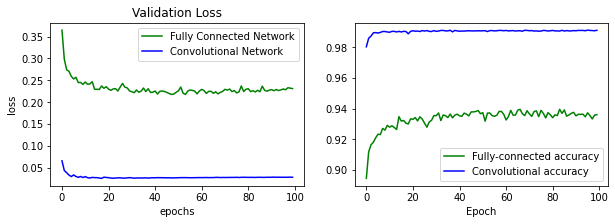

In [44]:
from matplotlib import pyplot
pyplot.figure(figsize=(10,3))
ax = pyplot.subplot(121)
# plot loss values of FC and CV network over epochs
ax.plot(fc_loss, "g-", label="Fully Connected Network")
ax.plot(cv_loss, "b-", label="Convolutional Network")
ax.set_xlabel('epochs')
ax.set_ylabel('loss')
ax.legend()
ax.set_title('Validation Loss')

ax = pyplot.subplot(122)
# plot accuracy values of FC and CV network over epochs
ax.plot(fc_acc, "g-", label="Fully-connected accuracy")
ax.plot(cv_acc, "b-", label="Convolutional accuracy")
ax.set_xlabel("Epoch")
ax.legend()


Task 10: Learnable Parameters 
-----------------------------

Estimate roughly how many learnable parameters the two networks have by analytically computing and adding the number of parameters in each layer.
Compute the number of parameters in the networks by summing the number of parameters in each layer using pytorch functionality.
You can use the `numel()` function from a `torch.Tensor` to provide the number of (learnable) parameters stored in a tensor.

Fully-connected Network:
- first fully-connected layer: (28 * 28 + 1) * 10 = 7850
- second fully-connected layer: (10 + 1) * 10 = 110
- third fully-connected layer: (10 + 1) * 10 = 110
- total: 8070

Convolutional Network:
- first convolutional layer: 32 * (1 * 5 * 5 + 1) = 800+32 = 832
- second convolutional layer: 64 * (32 * 5 * 5 + 1) = 51264
- fully-connected layer: (7 * 7 * 64 + 1) * 10= 31370
- total: 833466

<font color="#FF0000"> conv 也是有 bias 的，就是每一层的通道数</font>

In [57]:
def parameter_count(network):
  res = 0
  for params in network.parameters():
    if(params.requires_grad):
      res += params.numel()
  return res

print("Fully-connected Network:", parameter_count(fc))
print("Convolutional Network:", parameter_count(cv))

from torchsummary import summary
print("Fully-connected Network:")
summary(fc, (1, 28, 28))
print("Convolutional Network:")
summary(cv, (1, 28, 28))

Fully-connected Network: 8070
Convolutional Network: 83466
Fully-connected Network:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                   [-1, 10]           7,850
              Tanh-3                   [-1, 10]               0
            Linear-4                   [-1, 10]             110
              Tanh-5                   [-1, 10]               0
            Linear-6                   [-1, 10]             110
Total params: 8,070
Trainable params: 8,070
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.03
Estimated Total Size (MB): 0.04
----------------------------------------------------------------
Convolutional Network:
----------------------------------------------------------------
  